In [65]:
import requests
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
#fetch devin's evaluation outputs into a dataframe
def get_devin_eval_output():
    repo_url = "CognitionAI/devin-swebench-results"
    folder_path = "output_diffs"

    base_url = "https://api.github.com/repos/"
    pass_api_url = f"{base_url}{repo_url}/contents/{folder_path}/pass"
    failed_api_url = f"{base_url}{repo_url}/contents/{folder_path}/fail"

    files_info = []

    def get_files(api_url, subfolder_name):
        response = requests.get(api_url)
        if response.status_code == 200:
            contents = response.json()
            for item in tqdm(contents):
                if item["type"] == "file":
                    file_url = f"https://raw.githubusercontent.com/{repo_url}/main/{folder_path}/{subfolder_name}/{item['name']}"
                    file_content = requests.get(file_url).text
                    files_info.append({"instance_id":item['name'][:-9],"content": file_content, "pass or fail": subfolder_name})

    get_files(pass_api_url, "pass")
    get_files(failed_api_url, "fail")

    df = pd.DataFrame(files_info)
    return df

In [ ]:
#get the swe test dataset
swe_df = pd.DataFrame(load_dataset("princeton-nlp/SWE-bench", split="test"))
id2repo = {i:repo for i,repo in zip(swe_df.instance_id, swe_df.repo)}

In [60]:
df = get_devin_eval_output()
df['repo'] = [id2repo[i] for i in df.instance_id]
df.to_csv('../data/devin_output_diffs.csv', index=False)

Text(0.5, 1.0, "Devin's pass/fail status across repos")

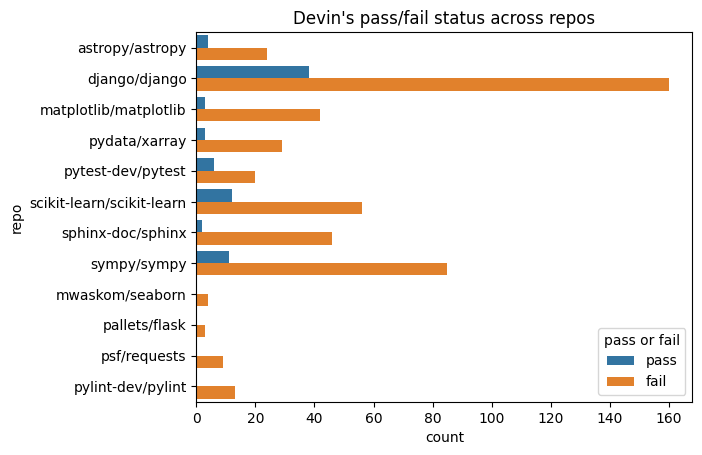

In [67]:
# check the pass/fail status of devin outputs across different repos
sns.countplot(y='repo', hue='pass or fail', data=df)
plt.title('Devin\'s pass/fail status across repos')

Text(0.5, 1.0, 'Number of Test Instances Under Each Repo: Devin vs. SWE-bench')

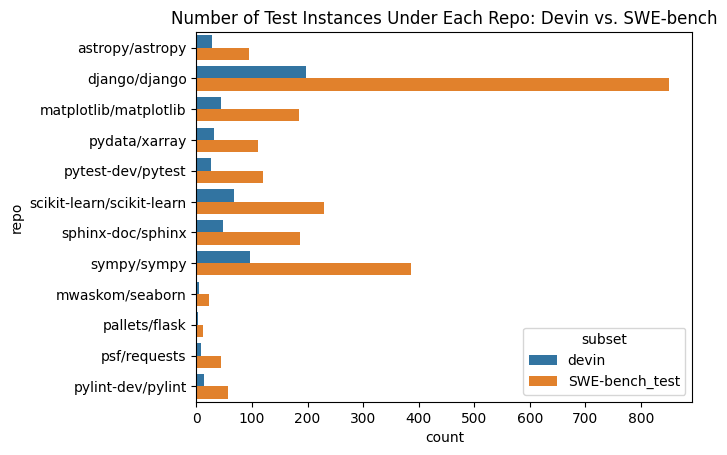

In [76]:
#check the distribution differences between SWE-bench test set and the subset devin used
swe_df['subset'] = 'SWE-bench_test'
df['subset'] = 'devin'
merged_df = pd.concat([df[['subset', 'repo']], swe_df[['subset', 'repo']]])
sns.countplot(y='repo', hue='subset', data=merged_df)
plt.title('Number of Test Instances Under Each Repo: Devin vs. SWE-bench')